In [2]:
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import sys
from sklearn.utils import shuffle
import h5py
import time
import seaborn as ses

from IPython import display
import pylab as pl

%matplotlib inline

# Model of one-layer GRU using tensorflow GRU cell

### load X,Y Data from folder /Data

In [3]:
def restore (nameOfFile,nameOfDataset):
    h5f = h5py.File(nameOfFile,'r')
    matrix = h5f[nameOfDataset][:]
    h5f.close()
    return matrix

In [4]:
X = restore("Data/data_matrix_X.h5","X")
Y = restore("Data/data_matrix_Y.h5","Y")

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.40,random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_test,y_test,test_size=0.50,random_state=42)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(700, 83, 27)
(700, 2)
(234, 83, 27)
(234, 2)
(233, 83, 27)
(233, 2)


### model tuning parameters

In [7]:
# size of input vector
input_size = 27
# nimber of hidden unit
hidden_size = 160
# number of output vector
output_size = 2

learn_rate = 0.001

batch_size = 700
epoch_number = 1300

## Define Model

In [8]:
class GruCell(object):
    
    def __init__(self,input_size , hidden_size , output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        #weight of output layer
        self.vo = tf.Variable(
            tf.random_normal([self.hidden_size,output_size],
                             mean=0,stddev=0.01,seed=1),name='vo')
        self.bo = tf.Variable(
            tf.ones([self.output_size]),name='bo')
        
        #define shape of input matrix  
        self.inputs_matrix = tf.placeholder(
            dtype=tf.float32 ,shape=[None,None,self.input_size],name='inputs_matrix')
        
    def get_outputs(self):
        """get all output for all states
    
        Returns:
            all_outputs: output matrix for all state  

        Note:
            returned matrix size (state_numbers , batch_number , output_size )
        """
        cell = tf.contrib.rnn.GRUCell(self.hidden_size)
        all_outputs , states = tf.nn.dynamic_rnn(cell, self.inputs_matrix, dtype=tf.float32)
        all_outputs = tf.transpose(all_outputs, [1, 0, 2])
        return all_outputs
    

## Define Model

In [9]:
# define GruCell class
rnn = GruCell(hidden_size=hidden_size,input_size=input_size,output_size=output_size)

#get all outputs 
outputs = rnn.get_outputs()

#get last state for batch
last_output = tf.gather(outputs, x_train.shape[1] - 1)

#apply softmax on all last states
output = tf.nn.softmax(tf.matmul(last_output,rnn.vo)+rnn.bo)

#define shape of y
y = tf.placeholder(tf.float32,shape=[None,output_size])

#compute Cost_function 
cross_entropy = -tf.reduce_sum(y * tf.log(tf.clip_by_value(output,1e-10,1.0)))/batch_size

#use AdamOptmizer to reduece error
optmizer_step = tf.train.AdamOptimizer().minimize(cross_entropy)

#compute accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(output,1))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32)))*100

# # compute error 
# mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
# error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

/home/moroclash/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Train Model


In [10]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


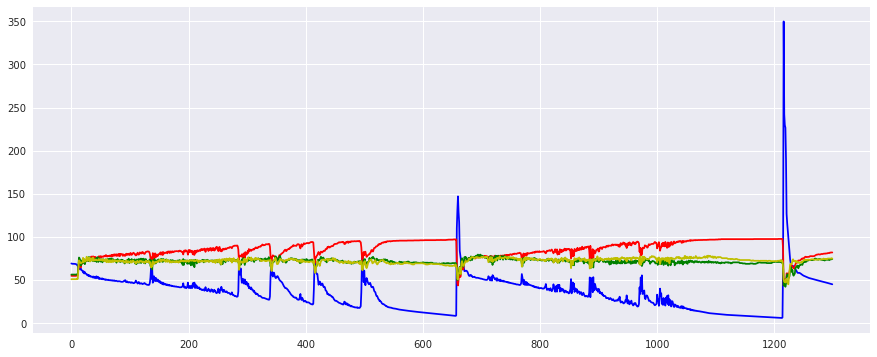

         Iteration:      1299 
               Loss:      44.9315965176 
     Train-Accuracy:      81.8571428571 
  Validate-Accuracy:      74.2489270386 
      test-Accuracy:      74.7863247863 

Improve count :: 10     79.3991416309 

--- 190.6124845703443 minute ---


In [11]:
start_time = time.time()
loss_fig=[]
test_accuracy_fig=[]
train_accuracy_fig=[]
validate_accuracy_fig=[]
epoch_fig=[]

best_validate_accuracy =0
improve_count = 0

def print_info():
    pl.figure(figsize=(15,6))
    pl.plot(epoch_fig,loss_fig,'b')
    pl.plot(epoch_fig,train_accuracy_fig,'r')
    pl.plot(epoch_fig,validate_accuracy_fig,'g')
    pl.plot(epoch_fig,test_accuracy_fig,'y')
    pl.show()

    sys.stdout.flush()
    print("\r         Iteration:      %s \n" 
          "               Loss:      %s \n"  
          "     Train-Accuracy:      %s \n"
          "  Validate-Accuracy:      %s \n"
          "      test-Accuracy:      %s \n"%(epoch,loss,train_accuracy,validate_acuuracy,test_acuuracy))
    print("Improve count :: %s     %s "%(improve_count,best_validate_accuracy))
    sys.stdout.flush()



pl.ion() 
for epoch in range(epoch_number):
    start = 0
    end = batch_size
    batchs_num = int(x_train.shape[0]/batch_size)
    for i in range(batchs_num):
        X = x_train[start:end]
        Y = y_train[start:end]
        start=end
        end=end+batch_size
        sess.run(optmizer_step,feed_dict={rnn.inputs_matrix:X,y:Y})
    
    loss = sess.run(cross_entropy,feed_dict={rnn.inputs_matrix:X,y:Y})*100
    train_accuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_train,y:y_train}) / len(x_train)
    validate_acuuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_validate,y:y_validate}) / len(x_validate)
    test_acuuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_test,y:y_test}) / len(x_test)

    #check best accuracy to save best pramaters
    if(best_validate_accuracy < validate_acuuracy):
        best_validate_accuracy=validate_acuuracy
        saver.save(sess, 'Pramaters/Model_3_using_TF_GRU')
        improve_count = improve_count+1
    
    epoch_fig.append(epoch)
    loss_fig.append(loss)
    train_accuracy_fig.append(train_accuracy)
    validate_accuracy_fig.append(validate_acuuracy)
    test_accuracy_fig.append(test_acuuracy)
    

    print_info()
    display.clear_output(wait=True)

    
print_info()
print("\n--- %s minute ---" % ((time.time() - start_time)/60))

# Model Info

 * input layer :: 27
 * hidden layer units :: 160
 * output layer :: 2
 
 * one-layer TF GRU
 * epoch : 1300
 * batch size : 700  "all training set"
 
 
  after 1300 epoch :    there is over fiting
 * Train-Accuracy:      81.8571428571 
 * Validate-Accuracy:      74.2489270386 
 * test-Accuracy:      74.7863247863
 
 
 #### note : we save pramaters after reach to the best Validate accurecy aftert 10 improvement 
 ####            best Validate accuracy : 79.399%
 ####  we use Gradient Clipping to reduce the effect of vanishing problem 

## Test model 

In [ ]:
#get all outputs of test set
test_outputs = rnn.get_outputs()
sess.run(test_outputs,feed_dict={rnn.inputs_matrix:x_test})
#get last state of last time step
last_test_output = test_outputs[-1]


In [ ]:
#apply softmax on last_test_output
y_predict = sess.run(tf.nn.softmax(last_test_output),feed_dict={rnn.inputs_matrix:x_test})

In [ ]:
#compute accuracy
correct_prediction = tf.equal(tf.argmax(y_predict,1),tf.argmax(y_test,1))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32))*100)/len(x_test)
print("Accuracy of test set :: %s "%(sess.run(accuracy)))


In [ ]:
num = 44
print(y_test[num])
print(y_predict[num])

## Retrive pramaters from Pramaters folder and test data

In [ ]:
import tensorflow as tf

#define new graph
new_graph = tf.Graph()
#start new session called sess2
with tf.Session(graph=new_graph) as sess2:  
    #define new_rnn
    new_rnn = GruCell(hidden_size=hidden_size,input_size=input_size,output_size=output_size)
    #get all outputs
    predicted_outputs = new_rnn.get_outputs()
    #initialize pramaters of new_rnn
    sess2.run(tf.initialize_all_variables())
    #define saver
    saver = tf.train.Saver()
    #get saved pramaters
    tf.train.import_meta_graph('Pramaters/Model_3_using_TF_GRU.meta')
    #get last checkpoint
    saver.restore(sess2,tf.train.latest_checkpoint('Pramaters/'))
    #run graph
    predicted_outputs = sess2.run(predicted_outputs,feed_dict={new_rnn.inputs_matrix:x_test})
    #get last time step
    last_test_output = predicted_outputs[-1]
    #apply softmax layer
    y_predict = sess2.run(tf.nn.softmax(last_test_output),feed_dict={new_rnn.inputs_matrix:x_test})
    #compute accuracy of test set
    correct_prediction = tf.equal(tf.argmax(y_predict,1),tf.argmax(y_test,1))
    accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32))*100)/len(x_test)
    print("Accuracy of test set :: %s "%(sess2.run(accuracy)))

